In [1]:
import pandas as pd
import numpy as np
from tqdm import trange
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS, Isomap
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/customers_m1.csv')

In [3]:
data.head()

,客户id,位置(新增),是否医保店,客户等级,客户店员数,是否有过投诉,连锁标记(更新2),注册时长,客户类型_医院,客户类型_单体药店,客户类型_卫生服务站,客户类型_诊所,客户类型_连锁药店
0,7081090359123820544,1.064867,0.972626,1.709349,-0.032001,-0.814386,-0.12702,-1.422691,False,False,False,True,False
1,6970904116784796290,-0.118820,0.972626,1.255499,0.344175,1.227912,-0.12702,1.096914,False,False,True,False,False
2,6970904089375019075,-1.302507,-1.028139,-1.013755,0.720350,1.227912,-0.12702,1.484774,False,False,True,False,False
3,6970903995691045348,-0.118820,0.972626,-1.013755,0.344175,-0.814386,-0.12702,1.102836,False,False,True,False,False
4,6970903992650174547,-0.118820,-1.028139,0.801648,0.720350,-0.814386,-0.12702,-0.262074,False,False,True,False,False


In [4]:
data.shape

(161086, 13)

# Kmeans聚类

In [5]:
score = {'ch_score': [], 'db_score':[]}
np.random.seed(42)
for k in trange(2, 30):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data.drop('客户id', axis=1))
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    ch_score = calinski_harabasz_score(data, labels)
    db_score = davies_bouldin_score(data, labels)
    score['ch_score'].append(ch_score)
    score['db_score'].append(db_score)

100%|██████████| 28/28 [01:11<00:00,  2.55s/it]


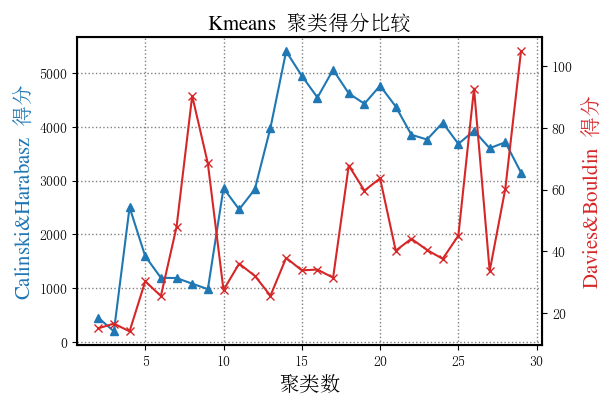

In [20]:
fig, ax1 = plt.subplots(figsize=(6, 4))
config = {
    "font.family":'serif',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
plt.rcParams.update(config)
# 绘制第一个数据集
ax1.plot(range(2, 30), score['ch_score'], color='tab:blue', marker='^', label='CH_score')
ax1.set_ylabel('$\mathrm{Calinski&Harabasz}$ 得分', color='tab:blue', fontsize=15)

# 创建一个与第一个轴共享x轴的新轴对象
ax2 = ax1.twinx()

# 绘制第二个数据集
ax2.plot(range(2, 30), score['db_score'], color='tab:red', marker='x', label='DB_score')
ax2.set_ylabel('$\mathrm{Davies&Bouldin}$ 得分', color='tab:red', fontsize=15)

# 添加标题和标签
plt.title('$\mathrm{Kmeans}$ 聚类得分比较', fontsize=15)
ax1.set_xlabel('聚类数', fontsize=15)

ax1.grid(ls=':', color='grey', lw=1)
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)
plt.show()

选择聚为7类

In [12]:
kmeans = KMeans(n_clusters=7, n_init=10)
kmeans.fit(data.drop('客户id', axis=1))
centers = kmeans.cluster_centers_
labels = kmeans.labels_

e:\anaconda3\envs\traffic\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


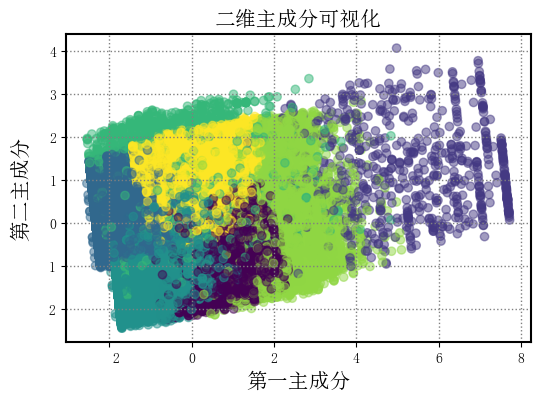

In [17]:
# 初始化PCA模型，指定降维后的维度为2
pca = PCA(n_components=2)

# 对数据进行降维
X_reduced = pca.fit_transform(data.drop('客户id', axis=1))

# 可视化降维后的数据
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('二维主成分可视化', fontsize=15)
plt.xlabel('第一主成分', fontsize=15)
plt.ylabel('第二主成分', fontsize=15)
plt.grid(ls=':', color='grey', lw=1)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.show()

In [24]:
%matplotlib auto
# 初始化PCA模型，指定降维后的维度为3
pca = PCA(n_components=3)

# 对数据进行降维
X_reduced = pca.fit_transform(data.drop('客户id', axis=1))

# 可视化降维后的数据，并根据聚类结果上色
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
for label in range(k):
    ax.scatter(X_reduced[labels == label, 0], X_reduced[labels == label, 1], X_reduced[labels == label, 2], label=f'Cluster {label+1}')
ax.set_title('PCA可视化', fontsize=15)
# 旋转坐标轴标签的方向
ax.view_init(elev=40, azim=30)
ax.set_xlabel('第一主成分', fontsize=15)
ax.set_ylabel('第二主成分', fontsize=15)
ax.set_zlabel('第三主成分', fontsize=15)
plt.show(block = True)

Using matplotlib backend: QtAgg


C:\Users\Bowen\AppData\Local\Temp\ipykernel_9180\3856955589.py:19: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.show(block = True)
